### Check type of GPU and VRAM available.

In [1]:
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

A100-SXM4-40GB, 40536 MiB, 40536 MiB


## Install Requirements

In [2]:
# Clone repos we need
!git clone https://github.com/Jan-Oliver/profaile-pic-dev.git

Cloning into 'profaile-pic-dev'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 145 (delta 16), reused 31 (delta 9), pack-reused 102
Receiving objects: 100% (145/145), 65.63 MiB | 16.29 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [14]:
!cd /content/profaile-pic-dev && pip install -r requirements.txt
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-4ftbxfni
  Running command git clone -q https://github.com/huggingface/diffusers.git /tmp/pip-req-build-4ftbxfni
  Installing build dependencies ... canceled
ERROR: Operation cancelled by user
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Set up WandB and Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import wandb
wandb.login(key="2e933b7b4892d6d2a225aa35820ab77a99d60116")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Hyperparameters

In [9]:
# Hyperparameters to indetify run in W&B
PROJECT_NAME = "stable-diffusion2-inpainting"
GROUP_NAME = "exp-finetuning-initial"

# Training hyperparameters 
# Precision to use
PRECISION = "no" # "fp16"
# Where the model will be stored
OUTPUT_DIR = "/content/stable_diffusion_weights/train"
# Google drive location of class images. Set to None if you want the model to create new ones.
CLASS_IMAGES_DIR_DRIVE = "/content/drive/MyDrive/StableDiffusion/class_pictures_man"
# Google drive location of instance images.
INSTANCE_IMAGES_DIR_DRIVE = "/content/drive/MyDrive/StableDiffusion/pictures_jseidenfuss/10"

In [7]:
# Leave as it is
MODEL_NAME="runwayml/stable-diffusion-inpainting"
!mkdir -p $OUTPUT_DIR

### Create concept

In [8]:
concepts_list = [
    {
        "instance_prompt":      "photo of jseidenfuss man",
        "class_prompt":         "photo of a man",
        "instance_data_dir":    "/content/data/instance_images",
        "class_data_dir":       "/content/data/class_images"
    }
]

# `class_data_dir` contains regularization images
import json
import os
for c in concepts_list:
    os.makedirs(c["instance_data_dir"], exist_ok=True)
    os.makedirs(c["class_data_dir"], exist_ok=True)

with open("concepts_list.json", "w") as f:
    json.dump(concepts_list, f, indent=4)

### Copy instance images into instance directory folder

In [10]:
import shutil
import glob
import tqdm 
for filename in tqdm.tqdm(glob.glob(os.path.join(INSTANCE_IMAGES_DIR_DRIVE, '*.*'))):
  shutil.copy(filename, concepts_list[0]["instance_data_dir"])

print()
if CLASS_IMAGES_DIR_DRIVE == None:
  print("No class images! Will use model to generate them.")
else:
  for filename in tqdm.tqdm(glob.glob(os.path.join(CLASS_IMAGES_DIR_DRIVE, '*.*'))):
    shutil.copy(filename, concepts_list[0]["class_data_dir"])

100%|██████████| 10/10 [00:02<00:00,  4.07it/s]


100%|██████████| 324/324 [00:01<00:00, 205.00it/s]


### Log instance images to wandb

In [11]:
run = wandb.init(project=PROJECT_NAME, group=GROUP_NAME, job_type="main")
# Log instance and class prompts
# The rest of the config is s
wandb.config.instance_prompt = concepts_list[0]["instance_prompt"]
wandb.config.class_prompt = concepts_list[0]["class_prompt"]

# Log instance images
wandb.log({"instance_images": [wandb.Image(os.path.join(concepts_list[0]["instance_data_dir"],image)) for image in os.listdir(concepts_list[0]["instance_data_dir"])]})

wandb: Currently logged in as: janoliver. Use `wandb login --relogin` to force relogin


### Train

In [26]:
!accelerate launch /content/train.py \
  --pretrained_model_name_or_path="/content/stable_diffusion_weights/train/1000" \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=3434554 \
  --resolution=512 \
  --train_batch_size=2 \
  --train_text_encoder \
  --mixed_precision="no" \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=100 \
  --sample_batch_size=4 \
  --max_train_steps=3000 \
  --save_interval=250 \
  --save_min_steps=500 \
  --save_infer_steps=50 \
  --concepts_list="concepts_list.json" \
  --not_cache_latents \
  --use_8bit_adam \
  --hflip

2022-12-27 20:31:11.232471: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
wandb: Currently logged in as: janoliver. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.13.7
wandb: Run data is saved locally in /content/wandb/run-20221227_203119-3vbw5mdr
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run rural-mountain-13
wandb: ⭐️ View project at https://wandb.ai/janoliver/uncategorized
wandb: 🚀 View run at https://wandb.ai/janoliver/u

### Preview results

IndexError: ignored

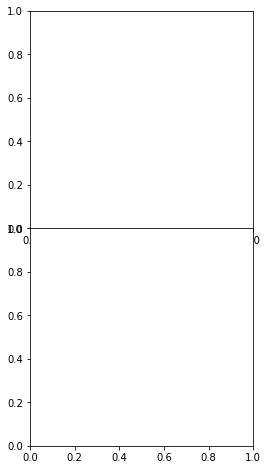

In [27]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

weights_folder = OUTPUT_DIR
folders = sorted([f for f in os.listdir(weights_folder) if f != "0"], key=lambda x: int(x))

row = len(folders)
col = len(os.listdir(os.path.join(weights_folder, folders[0], "samples")))
scale = 4
fig, axes = plt.subplots(row, col, figsize=(col*scale, row*scale), gridspec_kw={'hspace': 0, 'wspace': 0})

for i, folder in enumerate(folders):
    folder_path = os.path.join(weights_folder, folder)
    image_folder = os.path.join(folder_path, "samples")
    images = [f for f in os.listdir(image_folder)]
    for j, image in enumerate(images):
        if row == 1:
            currAxes = axes[j]
        else:
            currAxes = axes[i, j]
        if i == 0:
            currAxes.set_title(f"Image {j}")
        if j == 0:
            currAxes.text(-0.1, 0.5, folder, rotation=0, va='center', ha='center', transform=currAxes.transAxes)
        image_path = os.path.join(image_folder, image)
        img = mpimg.imread(image_path)
        currAxes.imshow(img, cmap='gray')
        currAxes.axis('off')
        
plt.tight_layout()
plt.savefig('grid.png', dpi=72)
wandb.log({"finetuning_results_overview": fig})

### Inference

**Github**:
- prompt (`str` or `List[str]`):
                The prompt or prompts to guide the image generation.
- image (`PIL.Image.Image`):
                `Image`, or tensor representing an image batch which will be inpainted, *i.e.* parts of the image will
                be masked out with `mask_image` and repainted according to `prompt`.
- mask_image (`PIL.Image.Image`):
                `Image`, or tensor representing an image batch, to mask `image`. White pixels in the mask will be
                repainted, while black pixels will be preserved. If `mask_image` is a PIL image, it will be converted
                to a single channel (luminance) before use. If it's a tensor, it should contain one color channel (L)
                instead of 3, so the expected shape would be `(B, H, W, 1)`.
- height (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The height in pixels of the generated image.
- width (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The width in pixels of the generated image.
- num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
- guidance_scale (`float`, *optional*, defaults to 7.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
- negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. Ignored when not using guidance (i.e., ignored
                if `guidance_scale` is less than `1`).
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
- eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [`schedulers.DDIMScheduler`], will be ignored for others.
- generator (`torch.Generator`, *optional*):
                One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
                to make generation deterministic.
- latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
- output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
- return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
                plain tuple.

In [28]:
# Util functions
from PIL import Image
PRECISION="fp16"
if PRECISION == "fp16":
    fp16 = True
else:
    fp16 = False

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [29]:
# Useful later when we actually use the depth2img model
INPAINTING_DIR = "/content/inpainting"
!mkdir $INPAINTING_DIR

In [32]:
for filename in glob.glob(os.path.join("/content/drive/MyDrive/StableDiffusion/pictures_band", '*.*')):
    shutil.copy(filename, INPAINTING_DIR)

### Which weights to load

In [31]:
WEIGHTS_DIR = os.path.join(OUTPUT_DIR, "1000")
print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")

[*] WEIGHTS_DIR=/content/stable_diffusion_weights/train/1000


In [30]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
import gradio as gr
from diffusers import StableDiffusionInpaintPipeline

In [45]:
#prompt = "face of jseidenfuss man , perfect eyes, front view, closeup, centered frame, symmetric, studio lighting, clear and realistic face, uhd faces, pexels, 85mm, casual pose, 35mm film roll photo, hard light, detailed skin texture, masterpiece, sharp focus, pretty, lovely, adorable, attractive, hasselblad, candid street portrait"
negative_prompt = "blender, jewlery, chain,ugly, different eye color ,multiple hands, bad anatomy, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white"
num_inference_steps = 70
guidance_scale = 7.5
generator = torch.Generator(device='cuda').manual_seed(52362)

output_type = "pil"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    WEIGHTS_DIR,
    revision="fp16", 
    torch_dtype=torch.float16,
).to("cuda")

"""def predict(img_dict, prompt):
  init_img =  img_dict['image'].convert("RGB").resize((512, 512))
  mask_img = img_dict['mask'].convert("RGB").resize((512, 512))

  output = pipe(
      prompt=prompt,
      negative_prompt=negative_prompt,
      image=init_img, 
      mask_image=mask_img, 
      strength=0.75,
      num_inference_steps=num_inference_steps,
      guidance_scale=guidance_scale,
      generator=generator,
      output_type=output_type)

  return(output.images[0])"""
def predict(dict, prompt):
  image =  dict['image'].convert("RGB").resize((512, 512))
  mask_image = dict['mask'].convert("RGB").resize((512, 512))
  images = pipe(
      prompt=prompt, 
      num_inference_steps=num_inference_steps,
      guidance_scale=guidance_scale,
      generator=generator,
      negative_prompt=negative_prompt,
      image=image, mask_image=mask_image).images
  return(images[0])

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [46]:
gr.Interface(
    predict,
    title = 'Stable Diffusion In-Painting Tool on Colab with Gradio',
    inputs=[
        gr.Image(source = 'upload', tool = 'sketch', type = 'pil'),
        gr.Textbox(label = 'prompt')
    ],
    outputs = [
        gr.Image()
        ]
).launch(debug = True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

  0%|          | 0/70 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (80 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['candid street portrait']


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.


In [ ]:
del pipe

### Store model

In [ ]:
artifact = wandb.Artifact('SD_D2I_2.0_2750_finetuned_jseidenfuss', type='model')
artifact.add_dir(os.path.join(OUTPUT_DIR, "2750"))
run.log_artifact(artifact)

run.finish()